In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tiki-books-dataset/comments.csv
/kaggle/input/tiki-books-dataset/book_data.csv
/kaggle/input/tiki-books-dataset/book_id.csv


# 1. Import Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.express as px
import cv2
from PIL import Image

plt.style.use("seaborn")
plt.rcParams['figure.figsize'] = (13, 7)

# 2. Load Data

In [3]:
id_df = pd.read_csv("/kaggle/input/tiki-books-dataset/book_id.csv")
data_df = pd.read_csv("/kaggle/input/tiki-books-dataset/book_data.csv")
cmt_df = pd.read_csv("/kaggle/input/tiki-books-dataset/comments.csv")

Let focus on data_df (main file).

In [4]:
data_df.head()

,product_id,title,authors,original_price,current_price,quantity,category,n_review,avg_rating,pages,manufacturer,cover_link
0,74021317,Cây Cam Ngọt Của Tôi,José Mauro de Vasconcelos,108000,64800,53075.0,Tiểu Thuyết,11481,5.0,244,Nhà Xuất Bản Hội Nhà Văn,https://salt.tikicdn.com/ts/product/5e/18/24/2...
1,74021317,Cây Cam Ngọt Của Tôi,José Mauro de Vasconcelos,108000,64800,53075.0,Tiểu Thuyết,11481,5.0,244,Nhà Xuất Bản Hội Nhà Văn,https://salt.tikicdn.com/ts/product/5e/18/24/2...
2,184466860,Hành Tinh Của Một Kẻ Nghĩ Nhiều,Nguyễn Đoàn Minh Thư,86000,59900,7929.0,Sách tư duy - Kỹ năng sống,780,4.8,184,Nhà Xuất Bản Thế Giới,https://salt.tikicdn.com/ts/product/d7/99/24/1...
3,73787185,Những Tù Nhân Của Địa Lý,Tim Marshall,210000,126000,17896.0,Lĩnh vực khác,3623,4.8,430,Nhà Xuất Bản Hội Nhà Văn,https://salt.tikicdn.com/ts/product/8d/96/9e/c...
4,52789367,Nhà Giả Kim (Tái Bản 2020),Paulo Coelho,79000,47400,24668.0,Tác phẩm kinh điển,5131,5.0,228,Nhà Xuất Bản Hà Nội,https://salt.tikicdn.com/ts/product/45/3b/fc/a...


In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1796 entries, 0 to 1795
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      1796 non-null   int64  
 1   title           1796 non-null   object 
 2   authors         1653 non-null   object 
 3   original_price  1796 non-null   int64  
 4   current_price   1796 non-null   int64  
 5   quantity        1751 non-null   float64
 6   category        1796 non-null   object 
 7   n_review        1796 non-null   int64  
 8   avg_rating      1796 non-null   float64
 9   pages           1546 non-null   object 
 10  manufacturer    1523 non-null   object 
 11  cover_link      1796 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 168.5+ KB


In [6]:
id_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2024 entries, 0 to 2023
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      2024 non-null   int64
dtypes: int64(1)
memory usage: 15.9 KB


We have 1796 books with duplicated. But in the id_df, we have 2024 ids. The reason for this issue is we crawled some thing not a book. Anaway, that isn't a big problem.

# 3. Data Preparation

## 3.1 Handle Value and Missing Data

In [7]:
data_df.isnull().sum()

product_id          0
title               0
authors           143
original_price      0
current_price       0
quantity           45
category            0
n_review            0
avg_rating          0
pages             250
manufacturer      273
cover_link          0
dtype: int64

### Title
Remove duplicated titles

In [8]:
data_df = data_df.drop_duplicates(subset=['title'])

In [9]:
data_df.authors.value_counts()

Nguyễn Nhật Ánh    24
Higashino Keigo    20
.                  18
Thích Nhất Hạnh    16
Haruki Murakami    15
                   ..
Urako Kanamori      1
Cổ Viên             1
Robert Winston      1
Yongchul Kwon       1
John C. Maxwell     1
Name: authors, Length: 1083, dtype: int64

As we can see, there are 18 "." authors, that's so weird hahaa. Let throw it away!

In [10]:
data_df.loc[data_df.authors == '.' , 'authors'] = "Unknown"

### Author

In [11]:
data_df.authors.value_counts()

Nguyễn Nhật Ánh    24
Higashino Keigo    20
Unknown            18
Thích Nhất Hạnh    16
Haruki Murakami    15
                   ..
Urako Kanamori      1
Cổ Viên             1
Robert Winston      1
Yongchul Kwon       1
John C. Maxwell     1
Name: authors, Length: 1083, dtype: int64

In [12]:
data_df.authors = data_df.authors.fillna("Unknown")

### Quantity

In [13]:
data_df.quantity = data_df.quantity.fillna(np.mean(data_df.quantity))

### Category

In [14]:
data_df.category.value_counts()

Sách tư duy - Kỹ năng sống                 292
Tiểu Thuyết                                133
Truyện ngắn - Tản văn - Tạp Văn            109
Sách nghệ thuật sống đẹp                    58
Sách kỹ năng làm việc                       55
                                          ... 
Shaman King - Tập 19                         1
Blue Period - Tập 07                         1
Komi - Nữ Thần Sợ Giao Tiếp - Tập 14         1
Bên Rặng Tuyết Sơn (Tái Bản)                 1
Kaguya-Sama: Cuộc Chiến Tỏ Tình - Tập 3      1
Name: category, Length: 354, dtype: int64

We have lot of wrong values. Just considering top 30 categories.

In [15]:
keeping_values = list(pd.DataFrame(data_df.category.value_counts()[1:30]).T.columns)
keeping_values

['Tiểu Thuyết',
 'Truyện ngắn - Tản văn - Tạp Văn',
 'Sách nghệ thuật sống đẹp',
 'Sách kỹ năng làm việc',
 'Bài học kinh doanh',
 'Truyện trinh thám',
 'Sách Học Tiếng Anh',
 'Sách Marketing - Bán hàng ',
 'Sách tài chính, tiền tệ',
 'Tác phẩm kinh điển',
 'Truyện Giả tưởng - Huyền Bí - Phiêu Lưu',
 'Kiến thức - Bách khoa',
 'Sách Làm Cha Mẹ',
 'Lĩnh vực khác',
 'Truyện dài',
 'Kiến Thức Bách Khoa',
 'Văn học thiếu nhi',
 'Light novel',
 'Truyện kể cho bé',
 'Sách quản trị, lãnh đạo',
 'Truyện đam mỹ',
 'Tiểu sử - Hồi ký',
 'Lịch Sử Thế Giới',
 'Sách Chiêm Tinh - Horoscope',
 'Sách Học Tiếng Hoa',
 'Truyện tranh Ehon',
 'Sách kinh tế học',
 'Sách giáo dục',
 'Tô màu - Luyện chữ  ']

In [16]:
def handle_category(category):
    if category not in keeping_values:
        return "Others"
    return category

data_df.category = data_df.category.apply(lambda category: handle_category(category))

### Pages

In [17]:
def handle_pages(lst_pages):
    lst_int = []
    for page in lst_pages:
        try:
            lst_int.append(int(page))
        except:
            continue
            
    return np.mean(lst_int)
    
mean_pages = handle_pages(list(data_df.pages))

In [18]:
data_df.pages = data_df.pages.fillna(str(mean_pages))

In [19]:
# There is one product having the value of pages is "Cuốn".
data_df.query('pages == "Cuốn"')

,product_id,title,authors,original_price,current_price,quantity,category,n_review,avg_rating,pages,manufacturer,cover_link
1266,197639028,Động Từ Bất Quy Tắc Và Ngữ Pháp Tiếng Anh Căn Bản,Mai Lan Hương,18000,12000,136.0,Sách Học Tiếng Anh,2,5.0,Cuốn,Nhà Xuất Bản Đà Nẵng,https://salt.tikicdn.com/ts/product/28/8e/9e/0...


Let remove it!

In [20]:
data_df = data_df.query('pages != "Cuốn"')

Let change datatype.

In [21]:
data_df.pages = data_df.pages.apply(lambda page: round(float(page)))
data_df.pages = data_df.pages.astype("int64")

In [22]:
data_df.pages.describe()

count      1768.000000
mean        455.603507
std        4561.569635
min          10.000000
25%         220.000000
50%         332.000000
75%         456.000000
max      192000.000000
Name: pages, dtype: float64

In [23]:
data_df[data_df.pages > 3000]

,product_id,title,authors,original_price,current_price,quantity,category,n_review,avg_rating,pages,manufacturer,cover_link
650,201687274,Có Một Nổi Buồn Vừa Ngang Qua Đây,Gã,88000,64900,114.0,Truyện ngắn - Tản văn - Tạp Văn,6,5.0,192000,Nhà Xuất Bản Văn Học,https://salt.tikicdn.com/ts/product/08/fd/a5/0...


Oh, there is one book with 192000 pages.

In [24]:
data_df = data_df.query('pages < 3000')

### Manufacturer

In [25]:
data_df.manufacturer.value_counts()

Nhà Xuất Bản Thế Giới                            247
NXB Trẻ                                          143
Nhà Xuất Bản Hà Nội                              128
Nhà Xuất Bản Dân Trí                             126
Nhà Xuất Bản Kim Đồng                            113
Nhà Xuất Bản Hội Nhà Văn                         111
Nhà Xuất Bản Thanh Niên                           97
Nhà Xuất Bản Tổng hợp TP.HCM                      91
Nhà Xuất Bản Lao Động                             89
Nhà Xuất Bản Văn Học                              76
Nhà Xuất Bản Hồng Đức                             56
Nhà Xuất Bản Công Thương                          46
Nhà Xuất Bản Phụ Nữ Việt Nam                      38
Nhà Xuất Bản Phụ Nữ                               30
Nhà Xuất Bản Đà Nẵng                              16
Nhà Xuất Bản Đại Học Quốc Gia Hà Nội              13
Nhà Xuất Bản Mỹ Thuật                              8
Nhà Xuất Bản Tri Thức                              7
Nhà Xuất Bản Lao Động Xã Hội                  

We can see some values using in the difference way:
* Nhà Xuất Bản Hồng Đức & hong duc
* Nhà Xuất Bản Dân Trí & NXB Dân Trí
* Nhà Xuất Bản Đại Học Quốc Gia Hà Nội & ĐHQG Hà Nội


Let grouping them

In [26]:
def handle_manufactuner(manufactuner):
    if manufactuner == "hong duc":
        return "Nhà Xuất Bản Hồng Đức"
    elif manufactuner == "NXB Dân Trí":
        return "Nhà Xuất Bản Dân Trí"
    elif manufactuner == "ĐHQG Hà Nội":
        return "Nhà Xuất Bản Đại Học Quốc Gia Hà Nội"
    else:
        return manufactuner
    
data_df.manufacturer = data_df.manufacturer.apply(lambda manufacturer: handle_manufactuner(manufacturer))

Handle missing values.

In [27]:
data_df.manufacturer = data_df.manufacturer.fillna("Unknown")

In [28]:
data_df.head()

,product_id,title,authors,original_price,current_price,quantity,category,n_review,avg_rating,pages,manufacturer,cover_link
0,74021317,Cây Cam Ngọt Của Tôi,José Mauro de Vasconcelos,108000,64800,53075.0,Tiểu Thuyết,11481,5.0,244,Nhà Xuất Bản Hội Nhà Văn,https://salt.tikicdn.com/ts/product/5e/18/24/2...
2,184466860,Hành Tinh Của Một Kẻ Nghĩ Nhiều,Nguyễn Đoàn Minh Thư,86000,59900,7929.0,Others,780,4.8,184,Nhà Xuất Bản Thế Giới,https://salt.tikicdn.com/ts/product/d7/99/24/1...
3,73787185,Những Tù Nhân Của Địa Lý,Tim Marshall,210000,126000,17896.0,Lĩnh vực khác,3623,4.8,430,Nhà Xuất Bản Hội Nhà Văn,https://salt.tikicdn.com/ts/product/8d/96/9e/c...
4,52789367,Nhà Giả Kim (Tái Bản 2020),Paulo Coelho,79000,47400,24668.0,Tác phẩm kinh điển,5131,5.0,228,Nhà Xuất Bản Hà Nội,https://salt.tikicdn.com/ts/product/45/3b/fc/a...
5,147920903,Một Thoáng Ta Rực Rỡ Ở Nhân Gian,Unknown,135000,81000,10000.0,Tiểu Thuyết,1636,4.8,304,Nhà Xuất Bản Hội Nhà Văn,https://salt.tikicdn.com/ts/product/2f/b5/4e/a...


### Create new column(s)
We have both original and current prices, let create discount column.

In [29]:
data_df['discount'] = round(1 - data_df['current_price']/data_df['original_price'],2)

The Vietnamese Dong currency is still long for visualization, so I decided to convert them into USD.

In [30]:
def convert_to_usd(vietnamdong):
    usd = vietnamdong/23700
    usd = round(usd, 2)
    
    return usd

data_df.original_price = data_df.original_price.apply(lambda vietnamdong: convert_to_usd(vietnamdong))
data_df.current_price = data_df.current_price.apply(lambda vietnamdong: convert_to_usd(vietnamdong))

## 3.2 Change Datatype

In [31]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1767 entries, 0 to 1795
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      1767 non-null   int64  
 1   title           1767 non-null   object 
 2   authors         1767 non-null   object 
 3   original_price  1767 non-null   float64
 4   current_price   1767 non-null   float64
 5   quantity        1767 non-null   float64
 6   category        1767 non-null   object 
 7   n_review        1767 non-null   int64  
 8   avg_rating      1767 non-null   float64
 9   pages           1767 non-null   int64  
 10  manufacturer    1767 non-null   object 
 11  cover_link      1767 non-null   object 
 12  discount        1766 non-null   float64
dtypes: float64(5), int64(3), object(5)
memory usage: 193.3+ KB


In [32]:
data_df.title = data_df.title.astype("string")
data_df.authors = data_df.authors.astype("string")
data_df.category = data_df.category.astype("string")
data_df.manufacturer = data_df.manufacturer.astype("string")
data_df.cover_link = data_df.cover_link.astype("string")

data_df.quantity = data_df.quantity.apply(lambda quantity: round(float(quantity)))
data_df.quantity = data_df.quantity.astype("int64")

### Save File For Tableau

In [33]:
data_df.to_csv("prepared_data_book.csv")

# 4. Exploratory Data Analysis (EDA)

In [34]:
data_df.head(1)

,product_id,title,authors,original_price,current_price,quantity,category,n_review,avg_rating,pages,manufacturer,cover_link,discount
0,74021317,Cây Cam Ngọt Của Tôi,José Mauro de Vasconcelos,4.56,2.73,53075,Tiểu Thuyết,11481,5.0,244,Nhà Xuất Bản Hội Nhà Văn,https://salt.tikicdn.com/ts/product/5e/18/24/2...,0.4


Let create a new dataset to visualization easily.

In [35]:
eda_df = data_df.drop(['product_id', 'cover_link'], axis=1)

## 4.1 Data Overviewing

### Price
* original_price
* current_price

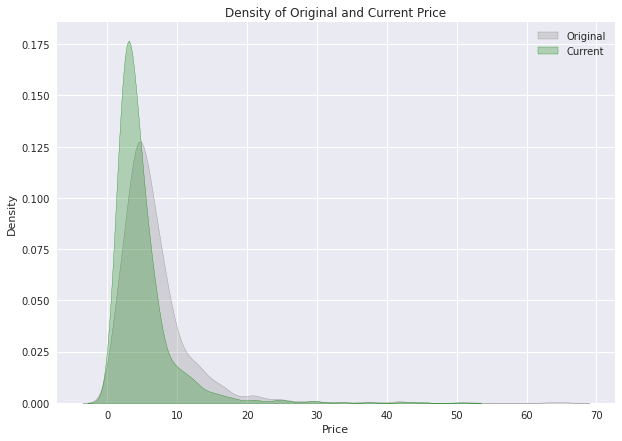

In [36]:
fig = plt.subplots(figsize=(10, 7))

ax = sns.kdeplot(eda_df.original_price, color='gray', shade=True, label='Original')
ax = sns.kdeplot(eda_df.current_price, color='g', shade=True, label='Current')

plt.xlabel('Price')
plt.title('Density of Original and Current Price')
plt.legend()
plt.show()

Look at the picture, the price of almost books is less than $20. There is a intering thing, that the price of books in Vietnam is so cheap.

### Discount per Category

We will focus on the discount baseded on category.

In [37]:
# Finding the mean of discount for each category.
eda_df.groupby('category').discount.mean()

category
Bài học kinh doanh                         0.263962
Kiến Thức Bách Khoa                        0.311739
Kiến thức - Bách khoa                      0.308485
Light novel                                0.250000
Lĩnh vực khác                              0.316774
Lịch Sử Thế Giới                           0.314286
Others                                     0.230339
Sách Chiêm Tinh - Horoscope                0.259286
Sách Học Tiếng Anh                         0.310750
Sách Học Tiếng Hoa                         0.182857
Sách Làm Cha Mẹ                            0.308125
Sách Marketing - Bán hàng                  0.254500
Sách giáo dục                              0.291538
Sách kinh tế học                           0.324615
Sách kỹ năng làm việc                      0.296364
Sách nghệ thuật sống đẹp                   0.281552
Sách quản trị, lãnh đạo                    0.286667
Sách tài chính, tiền tệ                    0.121750
Tiểu Thuyết                                0.353910
Tiể

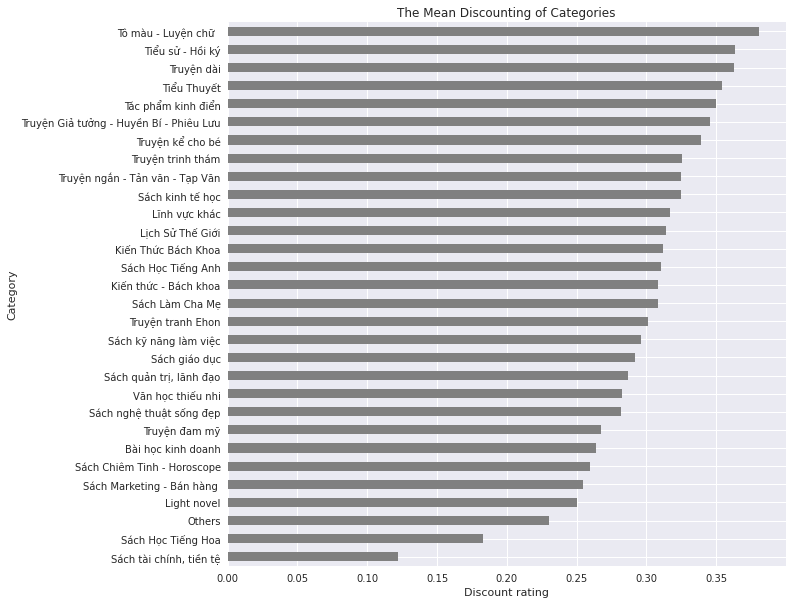

In [38]:
fig, ax = plt.subplots(figsize=(10,10))

ax=eda_df.groupby('category').discount.mean().sort_values(ascending=True).plot(kind='barh', color='gray')

plt.xlabel('Discount rating')
plt.ylabel('Category')
plt.title('The Mean Discounting of Categories')
plt.show()

Most of the discounted categories is tale (contain 'Truyen')

### Quantity per Category All of Time

Let see how the mean of selled books by each category.

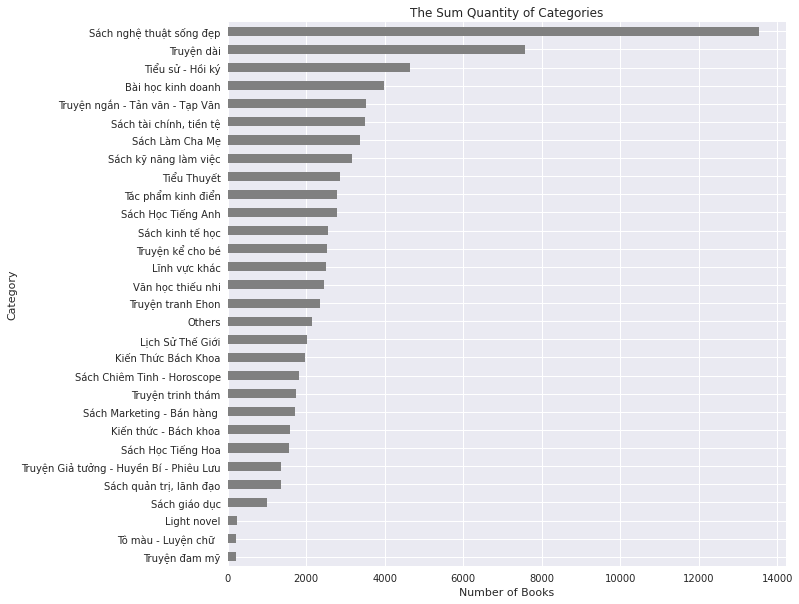

In [39]:
fig, ax = plt.subplots(figsize=(10,10))

ax=eda_df.groupby('category').quantity.mean().sort_values(ascending=True).plot(kind='barh', color='gray')

plt.xlabel('Number of Books')
plt.ylabel('Category')
plt.title('The Sum Quantity of Categories')
plt.show()

### Rating per Category

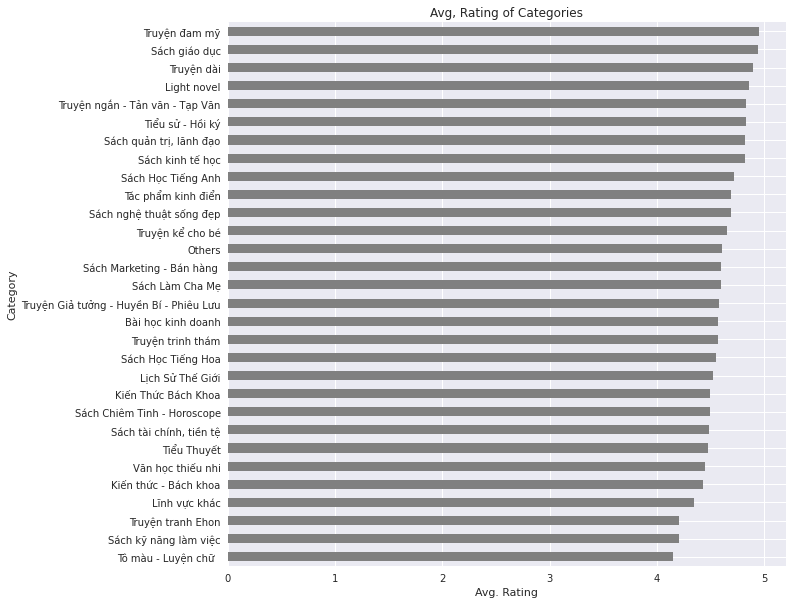

In [40]:
fig, ax = plt.subplots(figsize=(10,10))

ax=eda_df.groupby('category').avg_rating.mean().sort_values(ascending=True).plot(kind='barh', color='gray')

plt.xlabel('Avg. Rating')
plt.ylabel('Category')
plt.title('Avg, Rating of Categories')
plt.show()

All of categories have the mean of average rating larger than 4.0.

## 4.2 EDA

### The more pages, the more expensive?

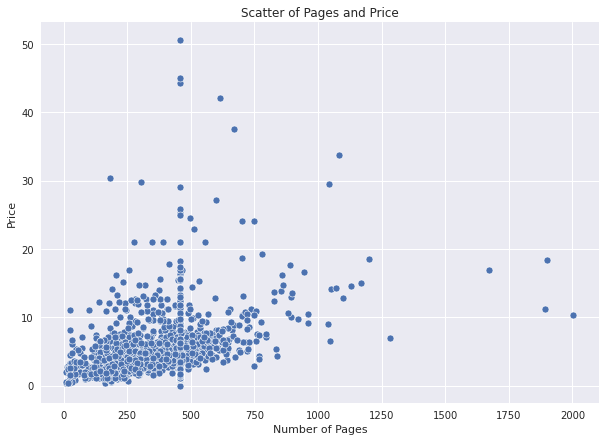

In [41]:
fig = plt.subplots(figsize=(10, 7))

ax=sns.scatterplot(data=eda_df, x='pages', y='current_price')#, color="",color_continuous_scale='RdBu_r')

plt.xlabel('Number of Pages')
plt.ylabel('Price')
plt.title('Scatter of Pages and Price')
plt.show()

There are some books with lartger pages and low price, and vice versa.

### What is the largest authors?

The assumption is that the author always in top 5 of:
* Quantity
* Number of Reviews
* Average Rating

In [42]:
def sort_authors_by_col(col):
    res = eda_df.groupby('authors')[col]\
        .mean()\
        .sort_values(ascending=False)\
        .index.tolist()
    
    return res

In [43]:
quantity_lst = sort_authors_by_col("quantity")
n_reviews_lst = sort_authors_by_col("n_review")
avg_rating_lst = sort_authors_by_col("avg_rating")

In [44]:
def top_k_common_elements(list1, list2, list3, k=10):
    list1, list2, list3 = list1[:k], list2[:k], list3[:k]
    return list(set(list1) & set(list2) & set(list3))
        
result = top_k_common_elements(quantity_lst, n_reviews_lst, avg_rating_lst, 100)
result

['Thái Phạm', 'GEORGE SAMUEL CLASON', 'Jack Canfield & DD.Watkins']

In the top 100 of the defined-assumption, we found three authors:
* Jack Canfield & DD.Watkins
* GEORGE SAMUEL CLASON
* Thái Phạm

Let see these book(s)!

In [45]:
# Jack Canfield & DD.Watkins
eda_df.query('authors == "Jack Canfield & DD.Watkins"')\
        .sort_values(by='quantity', ascending=False)\
        .reset_index(drop=True)\
        .drop(['authors'], axis=1)

,title,original_price,current_price,quantity,category,n_review,avg_rating,pages,manufacturer,discount
0,Người Nam Châm (Tái Bản 2019),2.74,1.94,14075,Sách kỹ năng làm việc,1774,5.0,194,Unknown,0.29


In [46]:
# Thái Phạm
eda_df.query('authors == "Thái Phạm"')\
        .sort_values(by='quantity', ascending=False)\
        .reset_index(drop=True)\
        .drop(['authors'], axis=1)

,title,original_price,current_price,quantity,category,n_review,avg_rating,pages,manufacturer,discount
0,Thiết Kế Cuộc Đời Thịnh Vượng - Design a Prosp...,12.62,12.62,15571,Others,2808,5.0,352,Nhà Xuất Bản Thế Giới,0.0
1,101 Lời Khuyên Tài Chính Cá Nhân Từ Thái Phạm,12.62,12.62,381,"Sách tài chính, tiền tệ",52,5.0,408,Nhà Xuất Bản Thế Giới,0.0


In [47]:
# GEORGE SAMUEL CLASON
eda_df.query('authors == "GEORGE SAMUEL CLASON"')\
        .sort_values(by='quantity', ascending=False)\
        .reset_index(drop=True)\
        .drop(['authors'], axis=1)

,title,original_price,current_price,quantity,category,n_review,avg_rating,pages,manufacturer,discount
0,Người Giàu Có Nhất Thành Babylon (Tái Bản 2020),4.14,2.73,12729,Bài học kinh doanh,2134,5.0,216,Nhà Xuất Bản Tổng hợp TP.HCM,0.34


### What is the best seller book?
The assumsion is that the book always in top 5 of:
* Quantity
* Number of Reviews
* Average Rating

In [48]:
def sort_title_by_col(col):
    # I used a trick here, because we group by title (without duplicated value).
    # The aim is to map with title against.
    res = eda_df.groupby("title")[col].max()\
        .sort_values(ascending=False)\
        .index.tolist()
    
    return res

In [49]:
quantity_lst = sort_title_by_col("quantity")
n_reviews_lst = sort_title_by_col("n_review")
avg_rating_lst = sort_title_by_col("avg_rating")

In [50]:
def top_k_common_elements(list1, list2, list3, k=10):
    list1, list2, list3 = list1[:k], list2[:k], list3[:k]
    return list(set(list1) & set(list2) & set(list3))
        
result = top_k_common_elements(quantity_lst, n_reviews_lst, avg_rating_lst, 200)
result

['Giải Thích Ngữ Pháp Tiếng Anh (Với Bài Tập Và Đáp Án) (Tái Bản)',
 'Muôn Kiếp Nhân Sinh 2',
 'Làm Bạn Với Bầu Trời (Bìa Mềm) (Tặng Kèm Khung Ảnh Số Lượng Có Hạn)',
 'Muôn Kiếp Nhân Sinh (Bìa Cứng)',
 'Không Sợ Chậm Chỉ Sợ Dừng\xa0',
 'Từ Tốt Đến Vĩ Đại (Tái bản 2021)']

In the top 200 of the defined-assumption, we found some titles. Let see these book(s)!

In [51]:
eda_df.loc[eda_df.title.isin(result)].reset_index(drop=True)

,title,authors,original_price,current_price,quantity,category,n_review,avg_rating,pages,manufacturer,discount
0,Giải Thích Ngữ Pháp Tiếng Anh (Với Bài Tập Và ...,Mai Lan Hương,9.28,6.41,5616,Sách Học Tiếng Anh,1014,5.0,560,Nhà Xuất Bản Đà Nẵng,0.31
1,Không Sợ Chậm Chỉ Sợ Dừng,Vãn Tình,5.44,3.50,13655,Sách nghệ thuật sống đẹp,2802,5.0,364,Nhà Xuất Bản Thế Giới,0.36
2,Từ Tốt Đến Vĩ Đại (Tái bản 2021),Unknown,5.49,3.96,8235,Sách kinh tế học,1119,5.0,484,NXB Trẻ,0.28
3,Muôn Kiếp Nhân Sinh (Bìa Cứng),Nguyên Phong,9.62,6.35,7391,Others,1421,5.0,424,Nhà Xuất Bản Tổng hợp TP.HCM,0.34
4,Làm Bạn Với Bầu Trời (Bìa Mềm) (Tặng Kèm Khung...,Nguyễn Nhật Ánh,4.64,3.16,26282,Truyện dài,2043,5.0,220,Unknown,0.32
5,Muôn Kiếp Nhân Sinh 2,Nguyên Phong,11.31,7.46,23606,Others,5447,5.0,540,Nhà Xuất Bản Tổng hợp TP.HCM,0.34
